http://artelab.dista.uninsubria.it/res/research/papers/2019/2019-IVCNZ-Nawaz-Birds.pdf

https://github.com/nicolalandro/ntsnet-cub200/blob/master/nts_net/model.py

In [1]:
# Standard library imports
import copy
import os
import random
import time
from datetime import datetime

# Third party imports
import cv2
import imgaug as ia
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image
from sklearn.metrics import accuracy_score
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

# Local application imports
from helper_functions import *

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


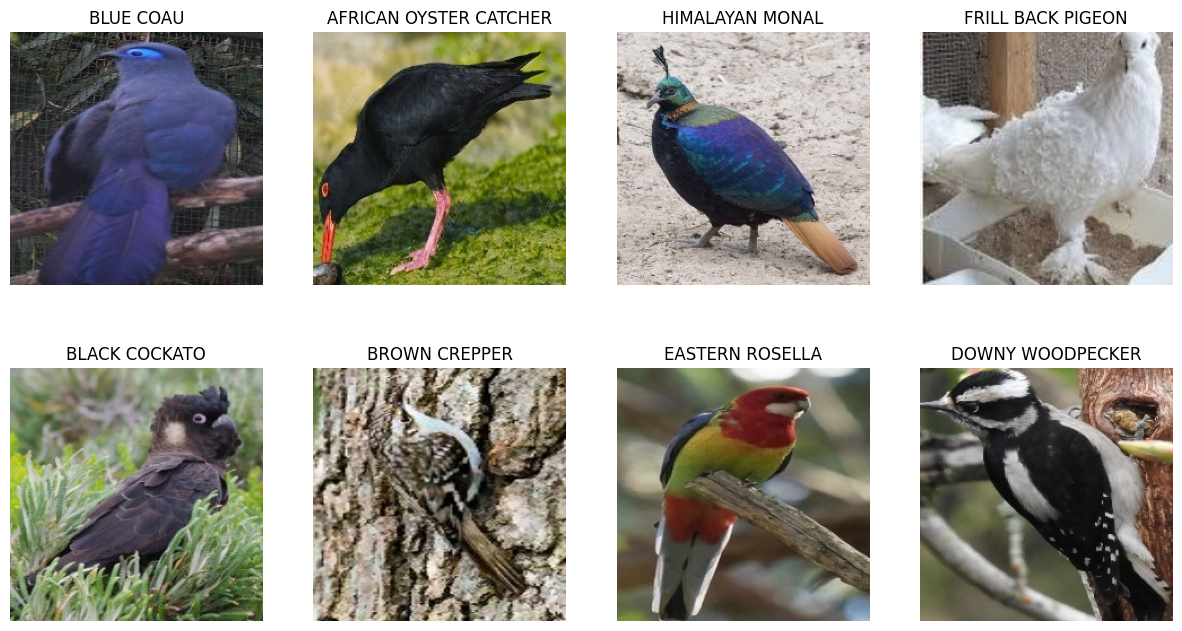

In [ ]:
show_random_birbs(img_dir="bird-525/train")

In [ ]:
get_height_width(path="bird-525\\train\\RED BROWED FINCH\\001.jpg")

The image size is 224 x 224


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
num_classes = 0
for root, dirs, files in os.walk("birds-525\\train-subset"):
    num_classes += len(dirs)

print(f"There are {num_classes} types of brids in the train dataset.")

There are 0 types of brids in the train dataset.


In [ ]:
# Define a transform to convert the data to PyTorch Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor()
])

# Load the training data
train_data = datasets.ImageFolder(
    root="birds-525\\train-subset",
    transform=transform
)

val_data = datasets.ImageFolder(
    root="birds-525\\valid-subset",
    transform=transform
)


# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=32,
    shuffle=False
)

In [ ]:
class BirbNet(nn.Module):
    def __init__(self, num_classes):
        super(BirbNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
model = BirbNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

epochs = 3
patience = 2

model, loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs, patience)

Step [10/39] | Loss: 1.6880232095718384 | Accuracy: 0.275
Step [20/39] | Loss: 1.279490351676941 | Accuracy: 0.4
Step [30/39] | Loss: 1.0429965257644653 | Accuracy: 0.5114583333333333
Epoch [1/3], Loss: 54.21716332435608, Accuracy: 0.5819209039548022, Validation Loss: 0.7173920571804047, Validation Accuracy: 0.875
Step [10/39] | Loss: 0.6950365900993347 | Accuracy: 0.88125
Step [20/39] | Loss: 0.5212661027908325 | Accuracy: 0.890625
Step [30/39] | Loss: 0.3564453125 | Accuracy: 0.9083333333333333
Epoch [2/3], Loss: 22.50523841381073, Accuracy: 0.9128329297820823, Validation Loss: 0.3561103641986847, Validation Accuracy: 0.925
Step [10/39] | Loss: 0.3727092742919922 | Accuracy: 0.940625
Step [20/39] | Loss: 0.4536702334880829 | Accuracy: 0.9390625
Step [30/39] | Loss: 0.3316865861415863 | Accuracy: 0.9385416666666667
Epoch [3/3], Loss: 14.819695770740509, Accuracy: 0.9322033898305084, Validation Loss: 0.2707165628671646, Validation Accuracy: 0.9


In [ ]:
save_model(model, "./models/birbnet.pt")

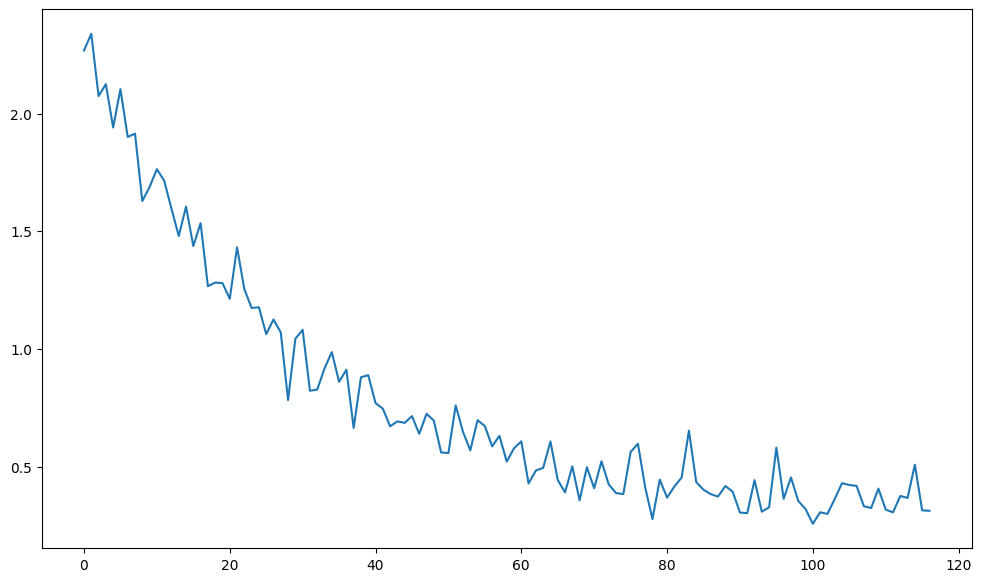

In [ ]:
plot_loss(loss_history, save=False)

## Classify new data

In [ ]:
def predict_image(model, image_path, show_image=False):
    # Ensure the model is in evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path)
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(input_image)
        _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the corresponding class label
    predicted_class_label = train_data.classes[predicted_class.item()]

    if show_image:# Display the image and the prediction
        plt.imshow(image)
        plt.title(f'Predicted class: {train_data.classes[predicted_class.item()]}')
        plt.axis(False)
        plt.show()

    return predicted_class_label

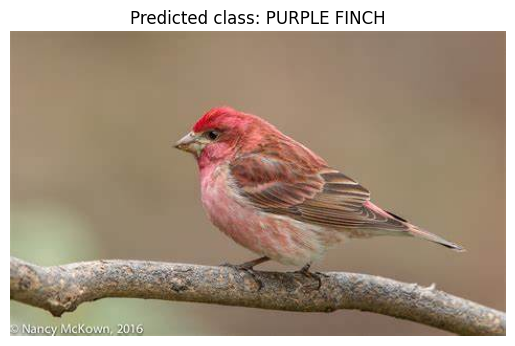

'PURPLE FINCH'

In [ ]:
predict_image(model, "birb-images/purple-finch.jpg", show_image=True)

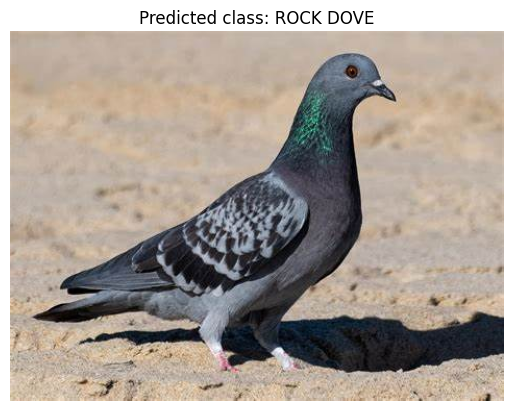

'ROCK DOVE'

In [ ]:
predict_image(model, "birb-images/rock-dove.jpg", show_image=True)

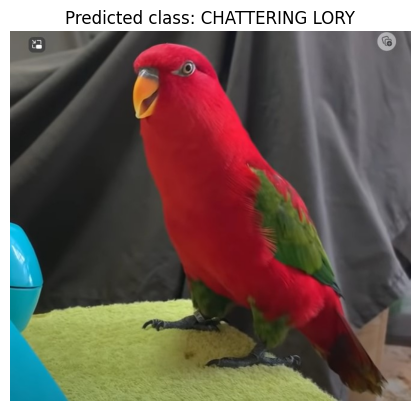

'CHATTERING LORY'

In [ ]:
predict_image(model, "birb-images/red-birb.jpg", show_image=True)

## Object detection on CUB 200-2011

Maybe try this:
- https://discuss.pytorch.org/t/how-to-load-cub-200-2011-in-pytorch/97784/2
- https://github.com/ChikinH/DeepLearning/blob/main/CUB_200_2011_CNN_YOLO.ipynb
- https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=Bj_riya9wjJI
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- https://github.com/Yangqing/iceberk/blob/master/visiondata/_cub.py

https://medium.com/@natsunoyuki/teaching-a-model-to-become-an-expert-at-locating-cats-and-dogs-in-images-716cdbc8d48f

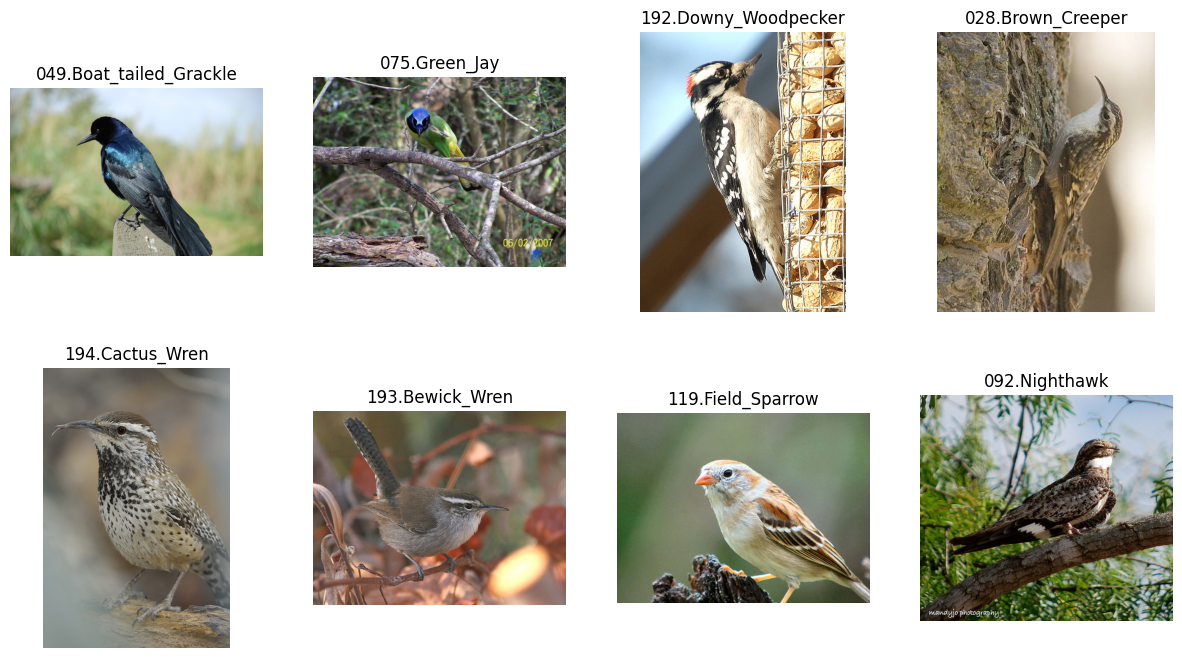

In [2]:
show_random_birbs(img_dir="./cub-200-2011/images")

In [2]:
get_height_width(path="./cub-200-2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg")

The image size is 320 x 223


In [2]:
def display_image_with_boxes(image_path, bounding_boxes):
    """
    Display an image with bounding boxes.

    Parameters:
    - image_path: str, path to the image file
    - bounding_boxes: list of lists, each inner list contains four values (x, y, width, height)
    """

    # Open the image file
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch for each bounding box and add it to the plot
    for box in bounding_boxes:
        x, y, width, height = box
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()

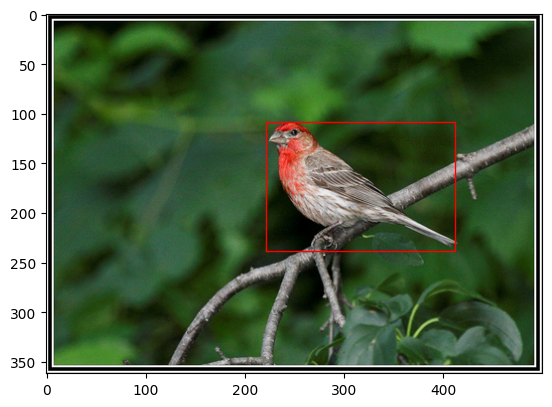

In [3]:
display_image_with_boxes("./cub-200-2011/images/035.Purple_Finch/Purple_Finch_0025_28174.jpg", [[221.0, 108.0, 191.0, 130.0]])


In [84]:
# Load the bounding boxes
bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# Convert the bounding box coordinates to float
bounding_boxes[["x", "y", "width", "height"]] = bounding_boxes[["x", "y", "width", "height"]].astype(float)

# Load the class labels
class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
class_labels.columns = ["Image", "Label"]

# Merge the two dataframes on the Image column
data = pd.merge(class_labels, bounding_boxes, on='Image')

# Create a list of ones with the same length as your data
objectness_labels = [1] * len(data)

# Convert the list to a pandas Series
objectness_labels = pd.Series(objectness_labels, name="Objectness")

# Add the objectness labels to your data
data = pd.concat([data, objectness_labels], axis=1)

In [85]:
data

Image  Label      x      y  width  height  Objectness
0          1      1   60.0   27.0  325.0   304.0           1
1          2      1  139.0   30.0  153.0   264.0           1
2          3      1   14.0  112.0  388.0   186.0           1
3          4      1  112.0   90.0  255.0   242.0           1
4          5      1   70.0   50.0  134.0   303.0           1
...      ...    ...    ...    ...    ...     ...         ...
11783  11784    200   89.0   95.0  354.0   250.0           1
11784  11785    200  157.0   62.0  184.0   219.0           1
11785  11786    200  190.0  102.0  198.0   202.0           1
11786  11787    200    3.0   20.0  408.0   307.0           1
11787  11788    200   20.0  113.0  177.0   263.0           1

[11788 rows x 7 columns]

In [86]:
# Load the image paths
image_paths = pd.read_csv("cub-200-2011/images.txt", sep=" ", header=None)
image_paths.columns = ["Image", "Path"]

# Create a dictionary that maps image IDs to image paths
image_paths_dict = dict(zip(image_paths["Image"], image_paths["Path"]))

# Add the image paths to the data DataFrame
data['Image_Path'] = data['Image'].map(image_paths_dict)

In [87]:
data["Image_Path"][0]

'001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'

In [88]:
data

Image  Label      x      y  width  height  Objectness  \
0          1      1   60.0   27.0  325.0   304.0           1   
1          2      1  139.0   30.0  153.0   264.0           1   
2          3      1   14.0  112.0  388.0   186.0           1   
3          4      1  112.0   90.0  255.0   242.0           1   
4          5      1   70.0   50.0  134.0   303.0           1   
...      ...    ...    ...    ...    ...     ...         ...   
11783  11784    200   89.0   95.0  354.0   250.0           1   
11784  11785    200  157.0   62.0  184.0   219.0           1   
11785  11786    200  190.0  102.0  198.0   202.0           1   
11786  11787    200    3.0   20.0  408.0   307.0           1   
11787  11788    200   20.0  113.0  177.0   263.0           1   

                                              Image_Path  
0      001.Black_footed_Albatross/Black_Footed_Albatr...  
1      001.Black_footed_Albatross/Black_Footed_Albatr...  
2      001.Black_footed_Albatross/Black_Footed_Albatr...  
3      001.Black_footed_Albatross/Black_Footed_Albatr...  
4      001.Black_footed_Albatross/Black_Footed_Albatr...  
...                                                  ...  
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11784  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11785  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11787  200.Common_Yellowthroat/Common_Yellowthroat_00...  

[11788 rows x 8 columns]

In [89]:
# # Load the bounding boxes
# bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
# bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# # Convert the bounding box coordinates to float
# bounding_boxes[["x", "y", "width", "height"]] = bounding_boxes[["x", "y", "width", "height"]].astype(float)

# # Load the class labels
# class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
# class_labels.columns = ["Image", "Label"]

# # Merge the two dataframes on the Image column
# data = pd.merge(class_labels, bounding_boxes, on='Image')

# # Create a list of ones with the same length as your data
# objectness_labels = [1] * len(data)

# # Convert the list to a pandas Series
# objectness_labels = pd.Series(objectness_labels, name="Objectness")

# # Add the objectness labels to your data
# data = pd.concat([data, objectness_labels], axis=1)

# # Load the image paths
# image_paths = pd.read_csv("cub-200-2011/images.txt", sep=" ", header=None)
# image_paths.columns = ["Image", "Path"]

# # Create a dictionary that maps image IDs to image paths
# image_paths_dict = dict(zip(image_paths["Image"], image_paths["Path"]))

# # Add the image paths to the data DataFrame
# data['Image_Path'] = data['Image'].map(image_paths_dict)

# # New size
# new_size = 224

# for i, row in data.iterrows():
#     # Get the image path
#     img_path = image_paths_dict.get(int(row["Image"]))

#     # If the image file was found, open the image and get its size
#     if img_path is not None:
#         with Image.open(f"cub-200-2011/images/{img_path}") as img:
#             original_width, original_height = img.size

#         # Define bounding boxes
#         bbs = BoundingBoxesOnImage([
#             BoundingBox(x1=row['x'], x2=row['x']+row['width'], y1=row['y'], y2=row['y']+row['height'])
#         ], shape=(original_height, original_width))

#         # Rescale bounding boxes
#         bbs_rescaled = bbs.on((new_size, new_size))

#         # Update the bounding box coordinates in the DataFrame
#         data.at[i, 'x'] = bbs_rescaled.bounding_boxes[0].x1
#         data.at[i, 'y'] = bbs_rescaled.bounding_boxes[0].y1
#         data.at[i, 'width'] = bbs_rescaled.bounding_boxes[0].width
#         data.at[i, 'height'] = bbs_rescaled.bounding_boxes[0].height

In [90]:
data

Image  Label      x      y  width  height  Objectness  \
0          1      1   60.0   27.0  325.0   304.0           1   
1          2      1  139.0   30.0  153.0   264.0           1   
2          3      1   14.0  112.0  388.0   186.0           1   
3          4      1  112.0   90.0  255.0   242.0           1   
4          5      1   70.0   50.0  134.0   303.0           1   
...      ...    ...    ...    ...    ...     ...         ...   
11783  11784    200   89.0   95.0  354.0   250.0           1   
11784  11785    200  157.0   62.0  184.0   219.0           1   
11785  11786    200  190.0  102.0  198.0   202.0           1   
11786  11787    200    3.0   20.0  408.0   307.0           1   
11787  11788    200   20.0  113.0  177.0   263.0           1   

                                              Image_Path  
0      001.Black_footed_Albatross/Black_Footed_Albatr...  
1      001.Black_footed_Albatross/Black_Footed_Albatr...  
2      001.Black_footed_Albatross/Black_Footed_Albatr...  
3      001.Black_footed_Albatross/Black_Footed_Albatr...  
4      001.Black_footed_Albatross/Black_Footed_Albatr...  
...                                                  ...  
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11784  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11785  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11787  200.Common_Yellowthroat/Common_Yellowthroat_00...  

[11788 rows x 8 columns]

In [11]:
def display_image_with_boxes_resized(image_path, bounding_boxes):
    """
    Display an image with bounding boxes.

    Parameters:
    - image_path: str, path to the image file
    - bounding_boxes: list of lists, each inner list contains four values (x, y, width, height)
    """

    # Open the image file
    img = Image.open(image_path)
    img = img.resize((224, 224))
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch for each bounding box and add it to the plot
    for box in bounding_boxes:
        x, y, width, height = box
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()

In [12]:
data.loc[1934]

Image                                                 1935
Label                                                   35
x                                                36.557861
y                                                28.224001
width                                           160.189911
height                                          169.792007
Objectness                                               1
Image_Path    035.Purple_Finch/Purple_Finch_0115_28190.jpg
Name: 1934, dtype: object

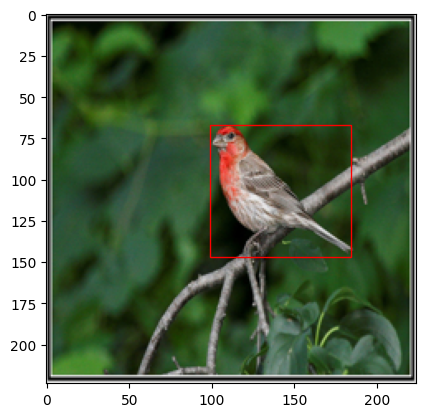

In [13]:
bird_id = 1932
display_image_with_boxes_resized(f"./cub-200-2011/images/{data.loc[bird_id]['Image_Path']}", [[data.loc[bird_id]["x"], data.loc[bird_id]["y"], data.loc[bird_id]["width"], data.loc[bird_id]["height"]]])

In [91]:
class BirdDataset(ImageFolder):
    def __init__(self, root, data, objectness_labels, transform=None):
        super().__init__(root, transform=transform)
        self.data = data
        self.objectness_labels = objectness_labels

    def __getitem__(self, index):
        # Get the image and label like usual
        img, label = super().__getitem__(index)
        
        # Add 1 to the label to reserve 0 for the background class
        label += 1

        # Get the image name from the file path
        image_name = self.imgs[index][0].split('/')[-1].split('.')[0]

        # Extract only the number from the image name
        image_number = ''.join(filter(str.isdigit, image_name))

        # Get the bounding box for this image
        bbox = self.data[self.data['Image'] == int(image_number)][['x', 'y', 'width', 'height']].values[0]

        # Convert the bounding box to [x1, y1, x2, y2] format
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

        # Get the objectness label for this image
        objectness_label = self.objectness_labels[int(image_number)]

        # Create a target dictionary
        target = {}
        target["boxes"] = torch.as_tensor([bbox], dtype=torch.float32)  # there is only one box per image
        target["labels"] = torch.as_tensor([label], dtype=torch.int64)  # assuming that the label is of type `int`
        target["image_id"] = torch.tensor([index])  # unique image id
        target["area"] = torch.tensor([(bbox[3] - bbox[1]) * (bbox[2] - bbox[0])], dtype=torch.float32)  # area of the bounding box
        target["iscrowd"] = torch.zeros((1,), dtype=torch.int64)  # assume there are no crowd in dataset

        return img, target

In [92]:
data

Image  Label      x      y  width  height  Objectness  \
0          1      1   60.0   27.0  325.0   304.0           1   
1          2      1  139.0   30.0  153.0   264.0           1   
2          3      1   14.0  112.0  388.0   186.0           1   
3          4      1  112.0   90.0  255.0   242.0           1   
4          5      1   70.0   50.0  134.0   303.0           1   
...      ...    ...    ...    ...    ...     ...         ...   
11783  11784    200   89.0   95.0  354.0   250.0           1   
11784  11785    200  157.0   62.0  184.0   219.0           1   
11785  11786    200  190.0  102.0  198.0   202.0           1   
11786  11787    200    3.0   20.0  408.0   307.0           1   
11787  11788    200   20.0  113.0  177.0   263.0           1   

                                              Image_Path  
0      001.Black_footed_Albatross/Black_Footed_Albatr...  
1      001.Black_footed_Albatross/Black_Footed_Albatr...  
2      001.Black_footed_Albatross/Black_Footed_Albatr...  
3      001.Black_footed_Albatross/Black_Footed_Albatr...  
4      001.Black_footed_Albatross/Black_Footed_Albatr...  
...                                                  ...  
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11784  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11785  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...  
11787  200.Common_Yellowthroat/Common_Yellowthroat_00...  

[11788 rows x 8 columns]

In [97]:
import shutil

# Define the number of classes you want to keep
num_classes = 3

# Create a new directory for the subset of classes
subset_dir = "cub-200-2011/subset"

# If the subset directory already exists, delete it
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)

os.makedirs(subset_dir, exist_ok=True)

# Get the list of class directories
class_dirs = sorted(os.listdir("cub-200-2011/images"))

# Keep only the first num_classes directories
class_dirs = class_dirs[:num_classes]

# Copy the first num_classes directories to the new directory
for class_dir in class_dirs:
    shutil.copytree(os.path.join("cub-200-2011/images", class_dir), os.path.join(subset_dir, class_dir))

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Then, when creating the BirdDataset, use this new directory
dataset = BirdDataset(subset_dir, data, objectness_labels=objectness_labels, transform=transform)

In [98]:
# Define a collate function for the DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)

In [99]:
len(dataset)

178

In [100]:
dataset[1]

(tensor([[[-0.1999, -0.0116,  0.1939,  ..., -1.2274, -1.1760, -1.1247],
          [-0.2171, -0.0287,  0.1768,  ..., -1.2445, -1.2274, -1.1932],
          [-0.4739, -0.2171,  0.0398,  ..., -1.0048, -1.0048, -1.0048],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  1.0159,  0.5022,  0.0912],
          [-2.1179, -2.1179, -2.1179,  ...,  0.3481, -0.0287, -0.2171],
          [-2.1179, -2.1179, -2.1179,  ..., -0.1828, -0.3541, -0.4739]],
 
         [[ 0.3102,  0.4853,  0.6254,  ..., -0.4076, -0.4426, -0.4076],
          [ 0.3277,  0.5028,  0.6429,  ..., -0.4076, -0.4076, -0.3901],
          [ 0.0826,  0.3277,  0.4853,  ..., -0.2150, -0.2325, -0.2325],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  1.6232,  1.3431,  0.9755],
          [-2.0357, -2.0357, -2.0357,  ...,  1.2206,  0.8354,  0.5728],
          [-2.0357, -2.0357, -2.0357,  ...,  0.6954,  0.4153,  0.2402]],
 
         [[ 0.9668,  1.1585,  1.2805,  ...,  0.3393,  0.4265,  0.4962],
          [ 0.9494,  1.1411,

In [101]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

class BirdNetOD(nn.Module):
    def __init__(self, num_classes):
        super(BirdNetOD, self).__init__()

        # Load the pretrained Faster R-CNN model
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        self.model.roi_heads.detections_per_img = 1

        # freeze model layers 
        for param in self.model.parameters():
            param.requires_grad = False

        # Get the number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        # Replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)

In [102]:
from torchinfo import summary 

model_od = BirdNetOD(num_classes=num_classes+1).to(device)
#print(summary(model_od, input_size=(32, 3, 224, 224)))

In [103]:
for name, param in model_od.named_parameters():
    print(name, param.requires_grad)

model.backbone.body.conv1.weight False
model.backbone.body.layer1.0.conv1.weight False
model.backbone.body.layer1.0.conv2.weight False
model.backbone.body.layer1.0.conv3.weight False
model.backbone.body.layer1.0.downsample.0.weight False
model.backbone.body.layer1.1.conv1.weight False
model.backbone.body.layer1.1.conv2.weight False
model.backbone.body.layer1.1.conv3.weight False
model.backbone.body.layer1.2.conv1.weight False
model.backbone.body.layer1.2.conv2.weight False
model.backbone.body.layer1.2.conv3.weight False
model.backbone.body.layer2.0.conv1.weight False
model.backbone.body.layer2.0.conv2.weight False
model.backbone.body.layer2.0.conv3.weight False
model.backbone.body.layer2.0.downsample.0.weight False
model.backbone.body.layer2.1.conv1.weight False
model.backbone.body.layer2.1.conv2.weight False
model.backbone.body.layer2.1.conv3.weight False
model.backbone.body.layer2.2.conv1.weight False
model.backbone.body.layer2.2.conv2.weight False
model.backbone.body.layer2.2.conv3.

In [104]:
torch.autograd.set_detect_anomaly(True)

In [105]:
import sys
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    loss_values = []
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Pass targets to model only in training mode
        model.train()
        loss_dict = model(images, targets)

        # Check if loss_dict is a dictionary
        if not isinstance(loss_dict, dict):
            print(f"Unexpected type for loss_dict at batch {i}")
            print(f"Skipping this batch")
            continue

        loss_classifier = loss_dict["loss_classifier"]
        loss_box_reg = loss_dict["loss_box_reg"]
        loss_objectness = loss_dict["loss_objectness"]
        loss_rpn_box_reg = loss_dict["loss_rpn_box_reg"]

        losses = sum([loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg])
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_values.append(loss_value)

        # # Get the model's predictions
        # with torch.no_grad():
        #     model.eval()
        #     predictions = model(images)

        # # Loop over all predictions
        # for pred, target in zip(predictions, targets):
        #     # Get the predicted and true labels
        #     pred_labels = pred['labels']
        #     true_labels = target['labels']
        #     print(pred_labels)
        #     print(true_labels)

        #     # Update the number of correct predictions
        #     accuracy = (pred_labels == true_labels).sum().item()

        # Update the progress bar
        print(f"Batch {i} of {len(data_loader)} | 'loss overall': {loss_value} | 'loss classifier' {loss_classifier}")

    metrics = {'loss_values': loss_values}
    return metrics


In [112]:
# Initialize the model
model = BirdNetOD(num_classes + 1)

# Move model to the right device
model = model.to(device)

# Choose the right optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0005)

# And the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of epochs
num_epochs = 2

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloader, device, epoch)
    
    # Update the learning rate
    lr_scheduler.step()

Batch 0 of 6 | 'loss overall': 2.169039011001587 | 'loss classifier' 1.7360596656799316
Batch 1 of 6 | 'loss overall': 2.2058749198913574 | 'loss classifier' 1.7662458419799805
Batch 2 of 6 | 'loss overall': 2.1093907356262207 | 'loss classifier' 1.7046300172805786
Batch 3 of 6 | 'loss overall': 1.9998303651809692 | 'loss classifier' 1.6921372413635254
Batch 4 of 6 | 'loss overall': 2.145101308822632 | 'loss classifier' 1.7365896701812744
Batch 5 of 6 | 'loss overall': 2.1128194332122803 | 'loss classifier' 1.6781316995620728
Batch 0 of 6 | 'loss overall': 2.0273311138153076 | 'loss classifier' 1.6323521137237549
Batch 1 of 6 | 'loss overall': 1.9707589149475098 | 'loss classifier' 1.5671533346176147
Batch 2 of 6 | 'loss overall': 1.9695656299591064 | 'loss classifier' 1.5714560747146606
Batch 3 of 6 | 'loss overall': 1.9023991823196411 | 'loss classifier' 1.5150741338729858
Batch 4 of 6 | 'loss overall': 1.9215961694717407 | 'loss classifier' 1.510748267173767
Batch 5 of 6 | 'loss ove

In [26]:
torch.save(model_od.state_dict(), "./models/birbnet-3-fasterrcnn-resnet50-fpn.pt")

In [113]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from PIL import Image
import torchvision.transforms as T
from torchvision.io import read_image
from pathlib import Path

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach()
            img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [119]:
import os
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, make_grid
from PIL import Image
import torch
import torchvision.transforms as T

def display_image_with_boxes(model, image_path, transform, label_names, color="red"):
    # resize image using the Image library 
    image = Image.open(image_path)
    # image = image.resize((224, 224))
    # temp_path = "temp.jpg"
    # image.save(temp_path)

    # transform the image for the model 
    image_transformed = transform(image)
    image_transformed = image_transformed.unsqueeze(0)

    # transform the image for viz
    uint_image = read_image(image_path)
    print(uint_image.shape)

    # Delete the temporary image file
    #os.remove(temp_path)    

    # Ensure the model is in evaluation mode
    model.eval()

    # Make a prediction
    with torch.no_grad():
        prediction = model(image_transformed.to(device))
        print(prediction)

    label = label_names[prediction[0]['labels'].item()]
    boxes = prediction[0]["boxes"]
    print(boxes)

    result = draw_bounding_boxes(uint_image, boxes=boxes, colors=[color], labels=[label], width=5)

    # Convert the tensor image to PIL image for displaying
    result = F.to_pil_image(result)

    show(result)

torch.Size([3, 3103, 4654])
[{'boxes': tensor([[1732.7136,  359.0876, 3661.4648, 1207.3099]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.6782], device='cuda:0')}]
tensor([[1732.7136,  359.0876, 3661.4648, 1207.3099]], device='cuda:0')


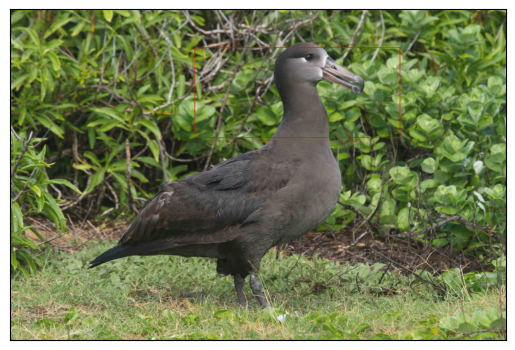

In [120]:
# Define the transformation
transform = T.Compose([
    #T.Resize((224, 224)),  # Resize the image to 224 x 224 pixels
    T.ToTensor()  # Convert the image to a tensor
])

# Call the function
display_image_with_boxes(model, "birb-images/black-footed-albatross.jpg", transform, label_names=class_dirs)